### Import libraries

In [2]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from datasets.cityscapes import CityScapes
from torchvision.transforms import ToPILImage
from fvcore.nn import FlopCountAnalysis, flop_count_table
from utils import fast_hist, per_class_iou
from models.bisenet.build_bisenet import BiSeNet

warnings.filterwarnings("ignore")

### Training

In [ ]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Set the device
device = torch.device("cuda")
# Load model
model = BiSeNet(context_path='resnet101', num_classes=19).to(device)
# Set model to training mode
model.train()

# Loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='train')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=1)

# Training loop
for epoch in range(50):
    # Initialize the hist matrix at each epoch
    hist = np.zeros((19, 19))
    # Iterate over the dataset
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        # Move the data to the device
        images = images.to(device)
        label = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(images)[0]
        # Compute the loss
        loss = criterion(output, label)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)
        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Update the learning rate
    poly_lr_scheduler(optimizer, 0.001, epoch, max_iter=len(dataloader))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/bisenet/bisenet_step2b/bisenet.pth')

Due to an error occurred during the training, the output is not available. \
However, the training script is correct and the model is saved. \
In particular, the training mIoU was around 0.76 while the loss was around 0.1.

### Evaluation

In [ ]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet101', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step2b/bisenet.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

# Evaluate the model
hist = np.zeros((19, 19))
for i, (images, labels) in enumerate(tqdm(dataloader)):
    # Move the data to the device
    images = images.to(device)
    label = labels.to(device)
    # Forward pass
    output = model(images)[0]
    # Compute the predictions
    pred = output.argmax(dim=0)

    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    miou = np.mean(per_class_iou(hist))

# Print the mIoU
print(f'mIoU: {miou}')

100%|██████████| 500/500 [00:15<00:00, 32.24it/s]

mIoU: 0.5814742022005452


### Example

0it [00:00, ?it/s]


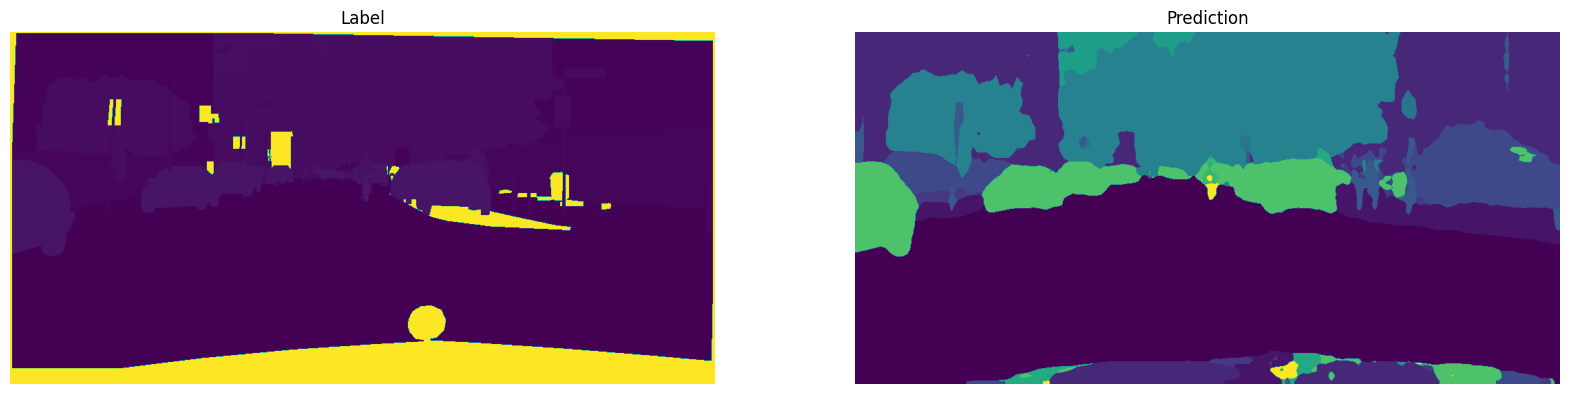

In [9]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet101', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step2b/bisenet.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    # Move the data to the device
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Stop after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### FLOPs and Parameters

In [10]:
# Get the device
device = torch.device("cuda")
# Load the model
model = BiSeNet(context_path='resnet101', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step2b/bisenet.pth'))
# Set model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the number of flops
flops = FlopCountAnalysis(model, image.unsqueeze(0).to(device))
# Get the number of flops
flops = flop_count_table(flops)
# Get the number of parameters
params = sum(p.numel() for p in model.parameters())

print(f'Number of parameters: {params}\n')
print(flops)

Number of parameters: 50801192

| module                                      | #parameters or shape   | #flops     |
|:--------------------------------------------|:-----------------------|:-----------|
| model                                       | 50.801M                | 91.923G    |
|  saptial_path                               |  0.371M                |  5.088G    |
|   saptial_path.convblock1                   |   1.856K               |   0.243G   |
|    saptial_path.convblock1.conv1            |    1.728K              |    0.226G  |
|    saptial_path.convblock1.bn               |    0.128K              |    16.777M |
|   saptial_path.convblock2                   |   73.984K              |   2.424G   |
|    saptial_path.convblock2.conv1            |    73.728K             |    2.416G  |
|    saptial_path.convblock2.bn               |    0.256K              |    8.389M  |
|   saptial_path.convblock3                   |   0.295M               |   2.42G    |
|    saptial_path.conv

### Latency and FPS

In [3]:
# Get the device
device = torch.device("cuda")

# Load the model
model = BiSeNet(context_path='resnet101', num_classes=19).to(device)
model.load_state_dict(torch.load('models/bisenet/bisenet_step2b/bisenet.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')

# Get the image and label
image, label = dataset[0]

# Compute the latency and FPS
iterations = 1000
latency = []
fps = []

# Run the model for a number of iterations
for _ in range(iterations):
    start = time()
    model(image.unsqueeze(0).to(device))
    end = time()
    latency.append(end - start)
    fps.append(1 / (end - start))

# Compute the average latency and FPS
mean_latency = np.mean(latency)
mean_fps = np.mean(fps)
std_latency = np.std(latency)
std_fps = np.std(fps)

# Print the results
print(f'Latency: {mean_latency:.3f} +/- {std_latency:.3f}')
print(f'FPS: {mean_fps:.3f} +/- {std_fps:.3f}')

Latency: 0.018 +/- 0.004
FPS: 55.471 +/- 3.928
